In [1]:
import pandas as pd
from utils.data import get_data

metabric_path = "data/METABRIC_CLIN_GE_CNA.csv"

# Load METABRIC
complete_data = pd.read_csv(metabric_path, index_col=None, header=0)
# Remove unknown classes
complete_data = complete_data.drop(
    complete_data[complete_data["Pam50Subtype"] == "?"].index
)
# Get pre-processed data
omics = get_data(complete_data, complete_data)
omics.keys()

/tmp/ipykernel_21861/4248701474.py:7: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data = pd.read_csv(metabric_path, index_col=None, header=0)


dict_keys(['ic', 'pam50', 'er', 'pr', 'her2', 'drnp', 'rnanp', 'cnanp', 'icnp', 'pam50np', 'ernp', 'prnp', 'her2np', 'clin'])

In [2]:
from utils.data import get_edge_index
import numpy as np

edge_index = get_edge_index(
    [
        omics["rnanp"],
        omics["cnanp"],
        omics["clin"],
    ],
    threshold=0.0035,
)

x = np.hstack((omics["rnanp"], omics["cnanp"], omics["clin"]))

y = omics["pam50np"]

In [3]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
from utils.data import get_pam50_labels


idx = np.arange(0, len(x), 1, dtype=int)
idx_train, idx_test, _, _ = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y
)
idx_train, idx_val, _, _ = train_test_split(
    idx_train, y[idx_train], test_size=0.2, random_state=42, stratify=y[idx_train]
)

mask_train = np.zeros(len(x), dtype=int)
mask_train[idx_train] = 1

mask_test = np.zeros(len(x), dtype=int)
mask_test[idx_test] = 1

mask_val = np.zeros(len(x), dtype=int)
mask_val[idx_val] = 1

dataset = Data(
    x=torch.tensor(x, dtype=torch.float32),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long),
)
dataset.train_mask = torch.tensor(mask_train, dtype=torch.bool)
dataset.test_mask = torch.tensor(mask_test, dtype=torch.bool)
dataset.val_mask = torch.tensor(mask_val, dtype=torch.bool)

dataset.pam50_labels = get_pam50_labels(omics["pam50"])
dataset.pam50 = omics["pam50"]

In [4]:
import time
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GATv2Conv


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, d_p=0.1):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATv2Conv(
            hidden_channels * heads, out_channels, heads=1, concat=False
        )
        self.d_p = d_p

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.d_p, training=self.training)
        h = F.elu(self.conv1(x, edge_index))
        x = F.dropout(h, p=self.d_p, training=self.training)
        y = self.conv2(x, edge_index)
        return y, h

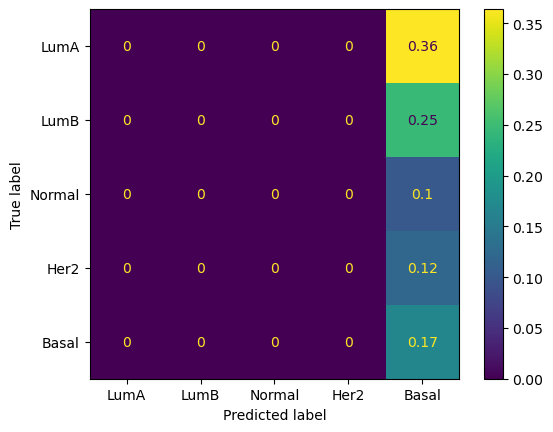

/home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/GATO/utils/data.py:17: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=y, palette=sns.color_palette("tab10"))


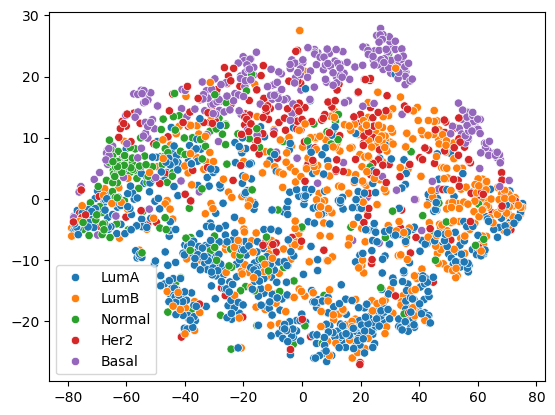

Epoch: 001, Loss: 1.7081, Train: 0.0570, Val: 0.0575, Test: 0.0573
Median time per epoch: 7.6660s


In [6]:
from sklearn.metrics import f1_score
from utils.data import plot_confusion_matrix, plot_latent_space


num_classes = 5
hidden_channels = 512
heads = 8
lr = 0.005
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

init_wandb(
    name=f"GAT-METABRIC",
    heads=heads,
    epochs=epochs,
    hidden_channels=hidden_channels,
    lr=lr,
    device=device,
)

data = dataset.to(device)
model = GAT(data.num_features, hidden_channels, num_classes, heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

df = pd.DataFrame(y[idx_train], columns=["gt_classes"])
class_weights = len(df["gt_classes"]) / df["gt_classes"].value_counts()
class_weights = torch.tensor(class_weights.to_list(), dtype=torch.float)
class_weights = class_weights.to(device)


def train():
    model.train()
    optimizer.zero_grad()
    out, _ = model(data.x, data.edge_index)
    loss = F.cross_entropy(
        out[data.train_mask], data.y[data.train_mask], weight=class_weights
    )
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(epoch):
    model.eval()
    pred, h = model(data.x, data.edge_index)
    pred = pred.argmax(dim=-1)

    f1s = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        f1s.append(
            f1_score(
                data.y[mask].cpu().numpy(), pred[mask].cpu().numpy(), average="macro"
            )
        )
    if epoch % 50 == 0:
        plot_confusion_matrix(
            data.y[data.val_mask].cpu().numpy(),
            pred[data.val_mask].cpu().numpy(),
            data.pam50_labels,
        )
        plot_latent_space(h.cpu().numpy(), data.pam50)

    return f1s


times = []
best_val_f1 = final_test_f1 = 0
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    train_f1, val_f1, tmp_test_f1 = test(epoch)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        test_f1 = tmp_test_f1
    log(Epoch=epoch, Loss=loss, Train=train_f1, Val=val_f1, Test=test_f1)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")